# DNN Classification with Tensorflow

## Prepare the data

### Import libraries and load the dataset

In [1]:
# import the libraries we will use
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read a CSV file, french style
df = pd.read_csv('Churn.csv',sep=',')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Split into training & testing data

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
# Separete the input data and the value to predict (the 'Exited' column).
# By convention: X is the input data and Y is the value to predict.
x_data = df.drop(['Exited'],axis=1)
y_val = df['Exited']

In [6]:
# Separate the dataset in two parts:
# 70% of the data will be used for training the model
# 30% to test it
X_train, X_test, y_train, y_true = train_test_split(x_data,y_val,test_size=0.3,random_state=101)

In [7]:
# X_train.describe()

### Scale the data

In [8]:
cols_to_scale=['CreditScore','Tenure','Balance','NumOfProducts','EstimatedSalary']

In [9]:
# Get around a bug in Sklearn / Pandas integration
# see https://stackoverflow.com/questions/45090639/pandas-shows-settingwithcopywarning-after-train-test-split
X_train.is_copy=None
X_test.is_copy=None

In [10]:
# X_train.head()

In [11]:
# apply min-max normalisation to specified columns
for col in cols_to_scale:
    xmin=X_train[col].min()
    dx=X_train[col].max()-xmin
    X_train[[col]] = X_train[[col]].apply(lambda x: ((x - xmin) / dx))
    X_test[[col]] = X_test[[col]].apply(lambda x: ((x - xmin) / dx))

In [12]:
X_train.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
803,804,15712825,Howells,0.322,Spain,Female,29,0.9,0.000000,0.333333,0,1,0.703471
1387,1388,15674526,Byrne,0.750,France,Male,66,0.4,0.344601,0.000000,1,1,0.707469
921,922,15743411,Chiawuotu,0.518,Spain,Male,61,0.1,0.000000,0.000000,1,0,0.112204
5917,5918,15812184,Rose,0.648,France,Female,31,0.1,0.000000,0.000000,1,0,0.644844
9610,9611,15812534,Chiemenam,0.210,France,Male,40,0.1,0.000000,0.666667,0,1,0.649952


In [13]:
# X_train.describe()

## Create the tensorflow estimator

In [14]:
import tensorflow as tf

### Create the 'feature columns'

In [15]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [16]:
# create the numeric columns
age = tf.feature_column.numeric_column('Age')
creditscore = tf.feature_column.numeric_column('CreditScore')
tenure = tf.feature_column.numeric_column('Tenure')
balance = tf.feature_column.numeric_column('Balance')
numproducts = tf.feature_column.numeric_column('NumOfProducts')
hascard = tf.feature_column.numeric_column('HasCrCard')
isactive = tf.feature_column.numeric_column('IsActiveMember')
estimated = tf.feature_column.numeric_column('EstimatedSalary')

In [17]:
# create categorical columns
geography = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(key='Geography',vocabulary_list=df['Geography'].unique()))
gender = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(key='Gender',vocabulary_list=df['Gender'].unique()))

In [18]:
# X_train['Age'].hist(bins=75)

In [19]:
# Discretize the age column 
age_b = tf.feature_column.bucketized_column(age, boundaries=[20,30,40,50,60,70,80])

In [20]:
feat_cols = [age_b,creditscore,tenure,balance,numproducts,hascard,isactive,estimated,geography,gender ]

### Create the input functions

In [21]:
# A first input function for training: feed the model with the training data & result
train_input_fn = tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train,batch_size=10,num_epochs=1000,shuffle=True)

In [22]:
# A second input function for testing: feed the model with the test data
test_input_func = tf.estimator.inputs.pandas_input_fn(
      x=X_test,
      num_epochs=1,
      shuffle=False)

### Create the estimator and train it

In [23]:
# Create a neural network with 3 layers of 10 neurons each
model = tf.estimator.DNNClassifier(hidden_units=[10,10,10],feature_columns=feat_cols,n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_model_dir': '/var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmps7azp675', '_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_log_step_count_steps': 100, '_session_config': None, '_keep_checkpoint_max': 5, '_tf_random_seed': 1}


In [24]:
# 7000 entries in X_train data = 1 epoch = 700 steps with batch of 10
# Go through the whole data set one time
model.train(input_fn=train_input_fn,steps=20000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmps7azp675/model.ckpt.
INFO:tensorflow:step = 1, loss = 7.22234
INFO:tensorflow:global_step/sec: 194.153
INFO:tensorflow:step = 101, loss = 6.29115 (0.525 sec)
INFO:tensorflow:global_step/sec: 154.396
INFO:tensorflow:step = 201, loss = 3.8602 (0.653 sec)
INFO:tensorflow:global_step/sec: 177.638
INFO:tensorflow:step = 301, loss = 3.37532 (0.567 sec)
INFO:tensorflow:global_step/sec: 195.191
INFO:tensorflow:step = 401, loss = 4.89656 (0.503 sec)
INFO:tensorflow:global_step/sec: 179.963
INFO:tensorflow:step = 501, loss = 6.14504 (0.563 sec)
INFO:tensorflow:global_step/sec: 193.68
INFO:tensorflow:step = 601, loss = 4.36354 (0.512 sec)
INFO:tensorflow:global_step/sec: 173.228
INFO:tensorflow:step = 701, loss = 2.28477 (0.576 sec)
INFO:tensorflow:global_step/sec: 197.898
INFO:tensorflow:step = 801, loss = 5.17959 (0.504 sec)
INFO:tensorflow:global_step/se

INFO:tensorflow:global_step/sec: 189.912
INFO:tensorflow:step = 8401, loss = 5.44018 (0.529 sec)
INFO:tensorflow:global_step/sec: 130.68
INFO:tensorflow:step = 8501, loss = 6.20945 (0.772 sec)
INFO:tensorflow:global_step/sec: 191.202
INFO:tensorflow:step = 8601, loss = 2.47326 (0.508 sec)
INFO:tensorflow:global_step/sec: 197.578
INFO:tensorflow:step = 8701, loss = 2.38382 (0.513 sec)
INFO:tensorflow:global_step/sec: 193.952
INFO:tensorflow:step = 8801, loss = 1.25294 (0.512 sec)
INFO:tensorflow:global_step/sec: 202.308
INFO:tensorflow:step = 8901, loss = 4.91465 (0.493 sec)
INFO:tensorflow:global_step/sec: 202.397
INFO:tensorflow:step = 9001, loss = 5.3792 (0.493 sec)
INFO:tensorflow:global_step/sec: 165.937
INFO:tensorflow:step = 9101, loss = 1.36519 (0.619 sec)
INFO:tensorflow:global_step/sec: 213.683
INFO:tensorflow:step = 9201, loss = 1.85857 (0.455 sec)
INFO:tensorflow:global_step/sec: 213.508
INFO:tensorflow:step = 9301, loss = 1.32468 (0.470 sec)
INFO:tensorflow:global_step/sec:

INFO:tensorflow:global_step/sec: 245.406
INFO:tensorflow:step = 16801, loss = 7.94516 (0.405 sec)
INFO:tensorflow:global_step/sec: 134.58
INFO:tensorflow:step = 16901, loss = 3.56316 (0.757 sec)
INFO:tensorflow:global_step/sec: 201.971
INFO:tensorflow:step = 17001, loss = 4.02011 (0.482 sec)
INFO:tensorflow:global_step/sec: 152.866
INFO:tensorflow:step = 17101, loss = 3.11319 (0.673 sec)
INFO:tensorflow:global_step/sec: 168.162
INFO:tensorflow:step = 17201, loss = 6.48911 (0.590 sec)
INFO:tensorflow:global_step/sec: 163.258
INFO:tensorflow:step = 17301, loss = 5.155 (0.609 sec)
INFO:tensorflow:global_step/sec: 189.17
INFO:tensorflow:step = 17401, loss = 1.54677 (0.523 sec)
INFO:tensorflow:global_step/sec: 189.119
INFO:tensorflow:step = 17501, loss = 1.48102 (0.530 sec)
INFO:tensorflow:global_step/sec: 226.004
INFO:tensorflow:step = 17601, loss = 0.989935 (0.435 sec)
INFO:tensorflow:global_step/sec: 215.067
INFO:tensorflow:step = 17701, loss = 4.51529 (0.461 sec)
INFO:tensorflow:global_

## Evaluate our estimator

In [25]:
predictions = model.predict(test_input_func)
pred_list = list(predictions)

INFO:tensorflow:Restoring parameters from /var/folders/2c/gpl2fhbx4kgft314vh0y0qq80000gn/T/tmps7azp675/model.ckpt-20000


In [26]:
y_pred = []
for p in pred_list:
    y_pred.append(p['class_ids'][0])

### Confusion Matrix

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [29]:
# Confusion matrix for prediction
cmp=confusion_matrix(y_true, y_pred)

In [30]:
cmp

array([[2284,   94],
       [ 328,  294]])

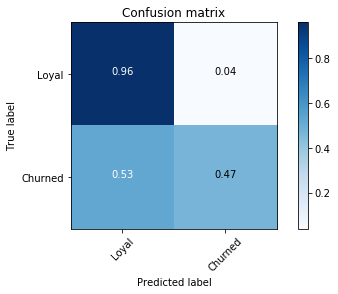

In [31]:
plot_confusion_matrix(cmp,["Loyal","Churned"],True)

### Classification Report

In [32]:
from sklearn.metrics import classification_report

In [34]:
print(classification_report(y_true,y_pred,target_names=["Loyal (0)","Churned (1)"]))

             precision    recall  f1-score   support

  Loyal (0)       0.87      0.96      0.92      2378
Churned (1)       0.76      0.47      0.58       622

avg / total       0.85      0.86      0.85      3000

